In [1]:
from astropy.io import fits as p
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy import misc
import numpy as np
import glob as g
import subprocess as s
import os, platform, copy
import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
home=os.getcwd()
workdir="/home/simon/Documents/Coma/Data/"
sextractor="sextractor"
det_filt='/usr/share/sextractor/gauss_1.5_3x3.conv'
if platform.system() == "Darwin":
	workdir="/Users/simon/Documents/Coma/Data/"
	sextractor="sex"
	det_filt="/usr/local/scisoft/packages/sextractor-2.5.0/config/gauss_1.5_3x3.conv"
os.chdir(workdir)
params1='NUMBER\nALPHA_J2000\nDELTA_J2000\nXWIN_IMAGE\nYWIN_IMAGE\nFLUX_RADIUS\nKRON_RADIUS\
\nMAG_APER\nMAG_AUTO\nELONGATION\nTHETA_IMAGE\nA_IMAGE\nB_IMAGE\nFLAGS\nFLUX_APER\n\
FLUXERR_APER\nSNR_WIN\nVIGNET(10,10)'
defparam1=open('default1.param','w')
defparam1.write(params1)
defparam1.close()
params2='NUMBER\nALPHA_J2000\nDELTA_J2000\nFLUX_RADIUS\nFWHM_IMAGE\nELLIPTICITY\nFWHMPSF_IMAGE\
\nMAG_AUTO\nMAGERR_AUTO\nMAG_PSF\nMAGERR_PSF\nMAG_MODEL\nMAGERR_MODEL\nSPREAD_MODEL\
\nSPREADERR_MODEL\nFLUX_MAX\nA_IMAGE\nB_IMAGE'
defparam2=open('default2.param','w')
defparam2.write(params2)
defparam2.close()

In [20]:
files=sorted(g.glob("*/*160*sci.fits"))#+g.glob("*336*sci.fits")+g.glob("*475*sci.fits")+g.glob("*814*sci.fits")
weights=sorted(g.glob("*/*160*wht.fits"))#+g.glob("*336*sci.fits")+g.glob("*475*sci.fits")+g.glob("*814*sci.fits")

In [21]:
print files,weights

['final_drz_sci_imgs/v01_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v02_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v03_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v04_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v05_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v06_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v07_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v08_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v09_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v10_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v11_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v12_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v13_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v14_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v15_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v16_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v17_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v18_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v20_F160W_WFC3_drz_sci.fits', 'final_drz_sci_imgs/v21_F160W_WFC3_drz_sci.fits',

u'/Users/simon/Documents/Coma/Data'

In [22]:
conditions={"F336W": 1.8,"F475W": 1.9,"F814W": 1.9,"F160W": 2.15}

In [57]:
conditions2={"F336W": 10,"F475W": 20,"F814W": 30,"F160W": 8}

In [58]:
filt="F160W"
sexfile=files[0]
iters=3
med_multiplier=1.1
skips=40
med_size=np.int(12*conditions[filt])
if med_size%2==0: med_size+=1
radius=int(med_size/2)
kernel = np.zeros((2*radius+1, 2*radius+1))
y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
mask = x**2 + y**2 <= radius**2
kernel[mask] = 1

Done SExtractor, time  0.632792949677
Done masking, time  1.66253209114
Done median-ing, time  4.47427201271
Next image saved


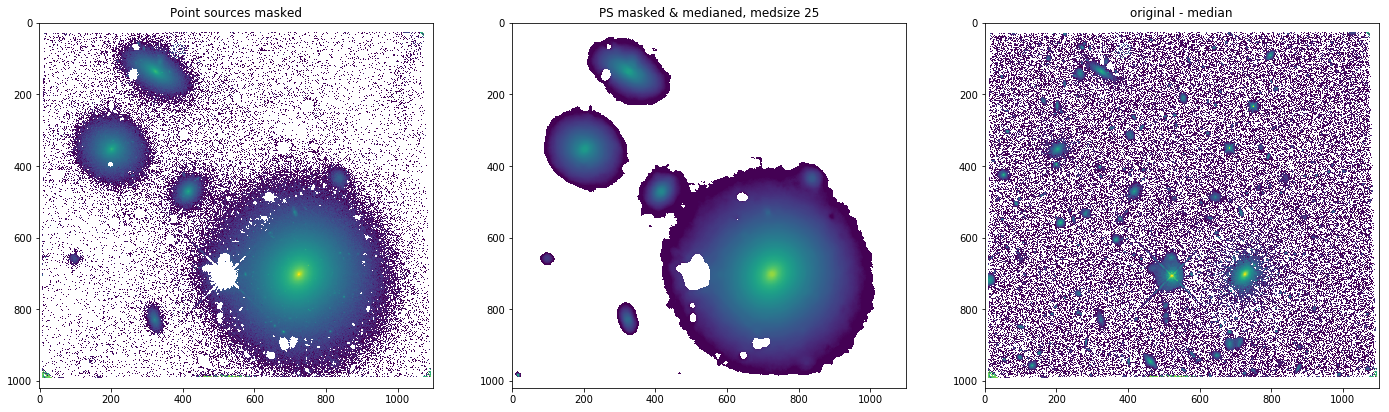

Done SExtractor, time  0.48917889595
Done masking, time  2.67337298393
Done median-ing, time  4.53244519234
Next image saved


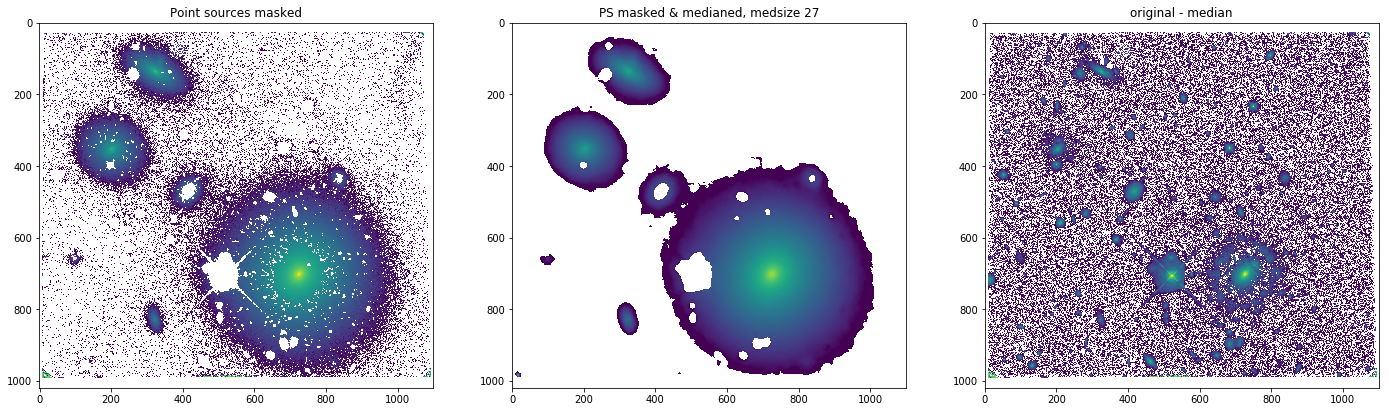

Done SExtractor, time  0.565528869629
Done masking, time  3.21855521202
Done median-ing, time  4.50336694717
Next image saved


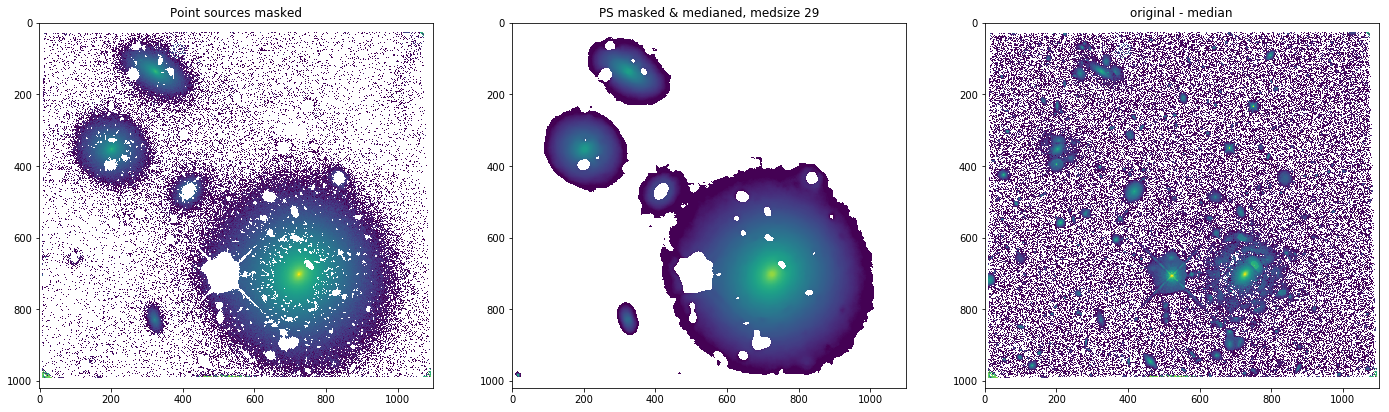

In [59]:
for j,sexfile in enumerate(files[::skips]):
    conforme=False
    hdu=p.open(sexfile)
    head=hdu[0].header
    data_orig=hdu[0].data
    data_orig=np.nan_to_num(data_orig)
    pix_scale=head["D001SCAL"]
    im_size=head['NAXIS1'],head['NAXIS2']
    zp=-2.5*np.log10(float(head['PHOTFLAM']))+float(head['PHOTZPT'])-5*np.log10(float(head['PHOTPLAM']))+18.6921
    i=0
    filt=head['PHOTMODE'].split()[2]
    border=min(im_size)
    #med_size=np.int(border/60)
    vmin=-2
    vmax=2.5
    w=weights[j]
    dataprime=copy.deepcopy(data_orig)
    s.call([sextractor,sexfile,'-PARAMETERS_NAME','default1.param','-FILTER_NAME',det_filt,\
                '-CATALOG_NAME',"original.cat",'-CATALOG_TYPE','FITS_LDAC','-VERBOSE_TYPE','QUIET',\
                '-WEIGHT_TYPE','MAP_WEIGHT','-WEIGHT_IMAGE',w,"-DETECT_THRESH","1.5","-ANALYSIS_THRESH","1.5"])
    for i in range(iters):
        #dataprime=copy.deepcopy(data_orig)
        if i==0: sex_file=sexfile
        else: sex_file='op%.0f.fits'%i
        checkimage_name="checkop%.0f.fits" %i
        cat_name="op%.0f.cat" %i
        sex_file_data=p.open(sex_file)[0].data
        t0=time.time()
        s.call([sextractor,sex_file,'-PARAMETERS_NAME','default1.param','-FILTER_NAME',det_filt,\
                '-CATALOG_NAME',cat_name,'-CATALOG_TYPE','FITS_LDAC','-VERBOSE_TYPE','QUIET',\
                '-CHECKIMAGE_TYPE','SEGMENTATION','-CHECKIMAGE_NAME', checkimage_name,\
                '-WEIGHT_TYPE','MAP_WEIGHT','-WEIGHT_IMAGE',w,"-DETECT_THRESH","1.5","-ANALYSIS_THRESH","1.5"])
        t1=time.time()
        print "Done SExtractor, time ",t1-t0
        cat_2=p.open(cat_name)
        cat_data=cat_2[2].data
        head2=cat_2[2].header
        a_image=cat_data["A_IMAGE"]
        b_image=cat_data["B_IMAGE"]
        not_galaxy_condition=((a_image<=conditions2[filt])&(cat_data["MAG_AUTO"]<99)&(a_image>0)&(b_image>0))
        not_gal_like=cat_data[not_galaxy_condition]
        not_gal_nums=not_gal_like["NUMBER"]    
        data_seg=p.open(checkimage_name)[0].data
        fig, axs = plt.subplots(1,3)
        fig.set_figwidth(24)
        fig.set_figheight(8)
      #  axs[0,0].imshow(np.log10(sex_file_data),vmin=vmin,vmax=vmax)
      #  axs[0,0].set_title("Original image")
        t0=time.time()
        for n in not_gal_nums:
            mask = data_seg==n 
            dataprime=np.where(~mask,dataprime,0)
           # print '{0}'.format(float(n)/len(not_gal_nums))
        if i == 0:
            compact_original=data_orig-dataprime
            p.writeto("compact_original.fits",not_gal_like,head2,clobber=True,output_verify='ignore')
        t1=time.time()
        print "Done masking, time ",t1-t0
        axs[0].imshow(np.log10(dataprime),vmin=vmin,vmax=vmax)
        axs[0].set_title("Point sources masked")
        t0=time.time()
        data_median=ndimage.median_filter(dataprime,med_size,footprint=kernel)
        t1=time.time()
        print "Done median-ing, time ",t1-t0
        axs[1].imshow(np.log10(data_median),vmin=vmin,vmax=vmax)
        axs[1].set_title("PS masked & medianed, medsize %.0f" %med_size)
        new_data=data_orig-data_median
        #new_data=new_data+np.abs(np.min(new_data))+0.001
        new_data=np.nan_to_num(new_data)
        #print np.abs(np.min(new_data))
        seg_image='op%.0f.fits'%(i+1)
        p.writeto(seg_image,new_data,head,clobber=True,output_verify='ignore')
        print "Next image saved"
        im = axs[2].imshow(np.log10(new_data),vmin=vmin,vmax=vmax)
        axs[2].set_title("original - median")
       # fig.colorbar(im,cax=axs[3])
        plt.show()
        plt.clf()
        med_size=np.int(np.floor(med_size*med_multiplier))
        if med_size%2==0: med_size+=1
        #conf=raw_input(u"Iteración %.0f. Está conforme? (Y/N)\n" %(i+1))
        #if conf=="Y" or conf=="y": conforme=True
    p.writeto("compact_final.fits",data_orig-dataprime,head,clobber=True,output_verify='ignore')
    s.call([sextractor,sex_file,'-PARAMETERS_NAME','default1.param','-FILTER_NAME',det_filt,\
                '-CATALOG_NAME',"compact_final.cat",'-CATALOG_TYPE','FITS_LDAC','-VERBOSE_TYPE','QUIET',\
                '-WEIGHT_TYPE','MAP_RMS','-WEIGHT_IMAGE',w,"-DETECT_THRESH","1.5","-ANALYSIS_THRESH","1.5"])
    params3='NUMBER\nALPHA_J2000\nDELTA_J2000\nFLUX_RADIUS\nELLIPTICITY\nMAG_APER(2)\nMAGERR_APER(2)\nFLUX_MAX\nA_IMAGE\nB_IMAGE'
    defparam3=open('default_comparison.param','w')
    defparam3.write(params3)
    defparam3.close()

In [40]:
print len(cat_data)


105


In [19]:

s.call([sextractor,sex_file,sexfile,'-PARAMETERS_NAME','default1.param','-FILTER_NAME',det_filt,\
                '-CATALOG_NAME',"compact_final_doublemode.cat",'-CATALOG_TYPE','FITS_LDAC','-VERBOSE_TYPE','QUIET',\
                '-WEIGHT_TYPE','MAP_RMS','-WEIGHT_IMAGE',w,"-DETECT_THRESH","1.5","-ANALYSIS_THRESH","1.5"])

0

In [20]:
h=p.open("compact_final.cat")
compact_data=h[2].data
h.close()
h=p.open("compact_final_doublemode.cat")
compact_data_double=h[2].data

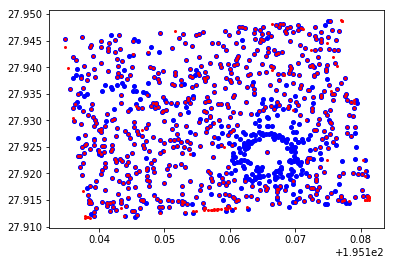

In [21]:
plt.plot(compact_data["ALPHA_J2000"],compact_data["DELTA_J2000"],"bo",markersize=4)
plt.plot(compact_data_double["ALPHA_J2000"],compact_data_double["DELTA_J2000"],"ro",markersize=2)

In [ ]:
compact_data.columns
cdata=compact_data[(compact_data["flux_radius"]<=4)&(compact_data["flux_radius"]>0)]

In [ ]:
fig, axs = plt.subplots(1,1)
fig.set_figwidth(8)
fig.set_figheight(8)
plt.scatter(cdata["ALPHA_J2000"],cdata["DELTA_J2000"],c=cdata["flux_radius"])
plt.show()
plt.hist(cdata["flux_radius"],bins=30)
plt.show()
plt.plot(cdata["flux_radius"],cdata["MAG_Aper"],"o",alpha=.3)

In [ ]:
s.call([sextractor,'compact_final.fits','-PARAMETERS_NAME','default_comparison.param','-FILTER_NAME',det_filt,\
                '-CATALOG_NAME',"compact_comparison.fits",'-CATALOG_TYPE','FITS_LDAC','-VERBOSE_TYPE','QUIET',\
                '-WEIGHT_TYPE','MAP_WEIGHT','-WEIGHT_IMAGE',w,"-DETECT_THRESH","1","-ANALYSIS_THRESH","1",\
           "-PHOT_APERTURES","4,6"])
s.call([sextractor,'compact_final.fits',sexfile,'-PARAMETERS_NAME','default_comparison.param','-FILTER_NAME',det_filt,\
                '-CATALOG_NAME',"compact_comparison_doubleimage.fits",'-CATALOG_TYPE','FITS_LDAC','-VERBOSE_TYPE','QUIET',\
                '-WEIGHT_TYPE','MAP_WEIGHT,MAP_WEIGHT','-WEIGHT_IMAGE',w+","+w,"-DETECT_THRESH","1","-ANALYSIS_THRESH","1",\
           "-PHOT_APERTURES","4,6"])

In [ ]:
fig=plt.figure(figsize=(40,40))
plt.imshow(np.log10(data_orig),cmap="gray",alpha=1)
plt.imshow(np.log10(data_orig-dataprime),cmap="inferno",alpha=1)
#plt.show()
plt.imshow(np.log10(compact_original),cmap="viridis",alpha=1)
plt.show()

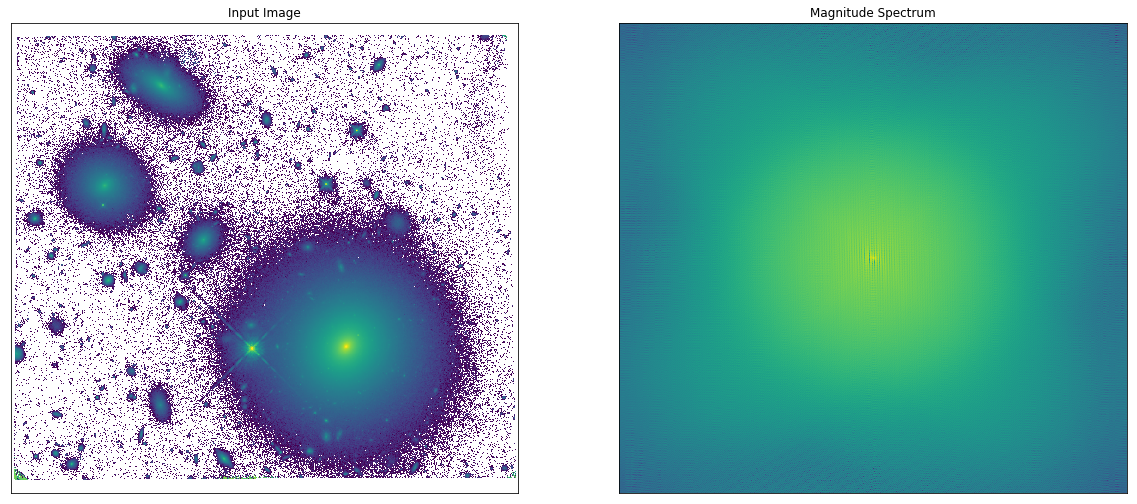

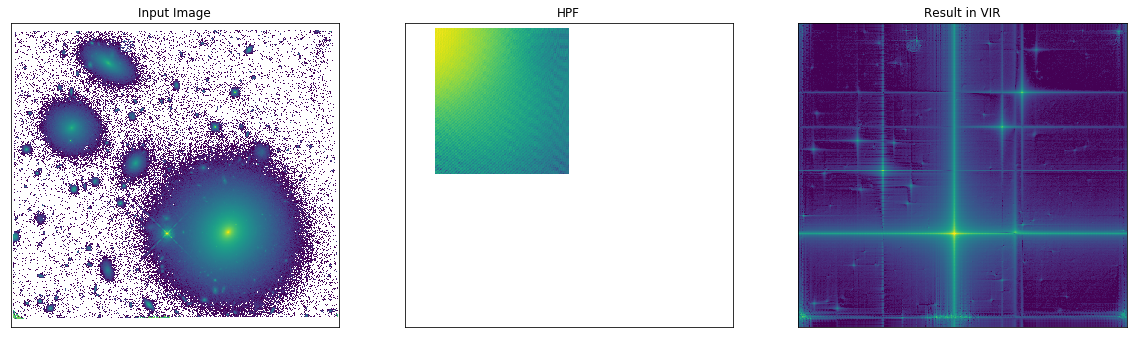

In [37]:
vmin=-2
vmax=2.5
hdu=p.open(sexfile)
head=hdu[0].header
img=np.nan_to_num(hdu[0].data)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift))
fig=plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(np.log10(img),vmin=vmin,vmax=vmax)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum)
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()
rows, cols = img.shape
crow,ccol = rows/2 , cols/2
mask_size=1000

fshiftprime=copy.deepcopy(fshift)
fshiftprime[crow-mask_size:crow+mask_size, ccol-mask_size:ccol+mask_size] = 0
fshift = fshift - fshiftprime

#fshift[crow-mask_size:crow+mask_size, ccol-mask_size:ccol+mask_size] = 0

f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
fig=plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(np.log10(img),vmin=vmin,vmax=vmax)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(np.log(np.abs(f_ishift)))
plt.title('HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(np.log10(img_back),vmin=vmin,vmax=vmax)
plt.title('Result in VIR'), plt.xticks([]), plt.yticks([])

plt.show()

In [17]:
print img_back

[[  2.39861576e-15   2.90248034e-15   2.94967178e-15 ...,   1.14877978e-15
    4.54101884e-15   1.65375499e-15]
 [  3.09855224e-15   2.48605580e-15   4.67502846e-15 ...,   2.43834633e-15
    4.04445160e-15   2.17319164e-15]
 [  1.91272615e-15   3.09991801e-15   5.81633914e-15 ...,   1.31926021e-15
    2.09002064e-15   1.26417387e-15]
 ..., 
 [  1.24732667e-15   2.54733409e-15   7.00445605e-15 ...,   1.87036412e-15
    1.28871898e-15   1.52308597e-15]
 [  1.01117355e-15   3.84072003e-15   6.41994202e-15 ...,   1.75532709e-15
    7.29337818e-16   1.43089367e-15]
 [  1.51052087e-15   1.57662056e-15   3.88161500e-15 ...,   1.15689959e-15
    1.54179954e-15   8.45846157e-16]]


In [ ]:
print np.unique(new_data), len(np.unique(new_data))
plt.hist(new_data.flatten(),log=True,bins=100)
plt.show()
plt.hist(np.log10(new_data.flatten()),log=True,bins=100)
plt.show()
plt.hist(np.log10(new_data).flatten(),log=True,bins=100)
plt.show()

In [ ]:
data_orig2=data_orig+np.abs(np.min(data_orig))+0.001
data_median2=data_median+np.abs(np.min(data_median))+0.001
plt.imshow(data_orig2)
plt.show()
plt.imshow(data_median2)
plt.show()
plt.hist(data_orig2.flatten(),log=True,bins=20)
plt.show()
plt.hist(data_median2.flatten(),log=True,bins=20)
plt.show()
plt.hist(np.log10(data_orig2.flatten()),log=True,bins=20,normed=True,histtype="step")
plt.hist(np.log10(data_median2.flatten()),log=True,bins=20,normed=True,histtype="step")
plt.show()

In [ ]:
data_fft=np.fft.fft2(data_orig)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(np.log(np.abs(data_fft)))
plt.colorbar()
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(np.log10(np.real(data_fft)))
plt.colorbar()
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(np.log10(np.imag(data_fft)))
plt.colorbar()
plt.show()

In [ ]:
print pix_scale

In [ ]:
print head["PHOTZPT"]

In [ ]:
print mask.shape
print dataprime.shape

In [ ]:
t0= time.time()
for i in range(100000000):
    pass
print time.time()-t0


In [ ]:
a=np.floor(2.222)
print a

In [ ]:
conforme=False
hdu=p.open(sexfile)
head=hdu[0].header
data_orig=hdu[0].data
data_orig=np.nan_to_num(data_orig)
pix_scale=head["D001SCAL"]
im_size=head['NAXIS1'],head['NAXIS2']
zp=-2.5*np.log10(float(head['PHOTFLAM']))+float(head['PHOTZPT'])-5*np.log10(float(head['PHOTPLAM']))+18.6921
i=0
border=min(im_size)
a_limit=0.1
if "160" in sexfile: a_limit=0.8
med_size=np.int(3*a_limit/pix_scale)
if med_size%2==0: med_size=med_size+1
vmin=-2
vmax=2.5
iters=5
for i in range(iters):
    dataprime=copy.deepcopy(data_orig)
    if i==0: sex_file=sexfile
    else: sex_file='op%.0f.fits'%i
    checkimage_name="checkop%.0f.fits" %i
    cat_name_psf="op_psf%.0f.cat" %i
    psf_name="op_psf%.0f.psf" %i
    cat_name="op%.0f.cat" %i
    sex_file_data=p.open(sex_file)[0].data
    t0=time.time()
    s.call([sextractor,sex_file,'-PARAMETERS_NAME','default1.param','-FILTER_NAME',filt,\
            '-CATALOG_NAME',cat_name_psf,'-CATALOG_TYPE','FITS_LDAC','-VERBOSE_TYPE','QUIET',\
            "-DETECT_THRESH","1.5","-ANALYSIS_THRESH","1.5"])
    t1=time.time()
    print "Done SExtractor 1, time ",t1-t0
    t0=time.time()
    s.call(['psfex',cat_name_psf,'-PHOTFLUX_KEY','FLUX_APER','-PHOTFLUXERR_KEY','FLUXERR_APER'\
            ,'-PSFVAR_NSNAP','4','-PSF_SIZE','15,15','-CHECKPLOT_TYPE','NONE','-CHECKIMAGE_TYPE','NONE'\
            ,'-NTHREADS','0',"-CENTER_KEYS","XWIN_IMAGE,YWIN_IMAGE","-PSFVAR_KEYS","XWIN_IMAGE,YWIN_IMAGE"])
    t1=time.time()
    print "Done PSFEx, time ",t1-t0

    t0=time.time()
    s.call([sextractor,sex_file,'-PARAMETERS_NAME','default2.param','-FILTER_NAME',filt,\
            '-CATALOG_NAME',cat_name,'-CATALOG_TYPE','FITS_LDAC','-VERBOSE_TYPE','QUIET',\
            '-CHECKIMAGE_TYPE','SEGMENTATION','-CHECKIMAGE_NAME', checkimage_name,\
            "-DETECT_THRESH","1.5","-ANALYSIS_THRESH","1.5","-PSF_NAME",psf_name])
    t1=time.time()
    print "Done SExtractor 2, time ",t1-t0
    cat_data=p.open(cat_name)[2].data
    a_image=cat_data["A_IMAGE"]
    b_image=cat_data["B_IMAGE"]
   # not_galaxy_condition=(cat_data["SPREAD_MODEL"]<0.1) & (cat_data["SPREAD_MODEL"]>0)\
   # & (cat_data["FLUX_RADIUS"]>0) & (cat_data["FLUX_RADIUS"]<1.5*np.mean(cat_data["FLUX_RADIUS"]))
    not_galaxy_condition=(cat_data["SPREAD_MODEL"]<0.1) & (cat_data["SPREAD_MODEL"]>0)\
    & (cat_data["FLUX_RADIUS"]>0) & (cat_data["FLUX_MAX"]<5)  
    not_gal_like=cat_data[not_galaxy_condition]
    not_gal_nums=not_gal_like["NUMBER"]    
    print len(not_gal_like)
    data_seg=p.open(checkimage_name)[0].data
    fig, axs = plt.subplots(1,3)
    fig.set_figwidth(24)
    fig.set_figheight(8)
  #  axs[0,0].imshow(np.log10(sex_file_data),vmin=vmin,vmax=vmax)
  #  axs[0,0].set_title("Original image")
    t0=time.time()
    for n in not_gal_nums:
        mask = data_seg==n 
        dataprime=np.where(~mask,dataprime,0)
       # print '{0}'.format(float(n)/len(not_gal_nums))
    t1=time.time()
    print "Done masking, time ",t1-t0
    axs[0].imshow(np.log10(dataprime),vmin=vmin,vmax=vmax)
    axs[0].set_title("Point sources masked")
    t0=time.time()
    data_median=ndimage.median_filter(dataprime,med_size)
    t1=time.time()
    print "Done median-ing, time ",t1-t0
    axs[1].imshow(np.log10(data_median),vmin=vmin,vmax=vmax)
    axs[1].set_title("PS masked & medianed, medsize %.0f" %med_size)
    new_data=data_orig-data_median
    #new_data=new_data+np.abs(np.min(new_data))+0.001
    new_data=np.nan_to_num(new_data)
    #print np.abs(np.min(new_data))
    seg_image='op%.0f.fits'%(i+1)
    p.writeto(seg_image,new_data,head,clobber=True,output_verify='ignore')
    print "Next image saved"
    im = axs[2].imshow(np.log10(new_data),vmin=vmin,vmax=vmax)
    axs[2].set_title("original - median")
   # fig.colorbar(im,cax=axs[3])
    plt.show()
    plt.clf()
    med_size=np.int(np.floor(med_size*med_multiplier))
    if med_size%2==0: med_size=med_size+1
    #conf=raw_input(u"Iteración %.0f. Está conforme? (Y/N)\n" %(i+1))
    #if conf=="Y" or conf=="y": conforme=True
    #i=i+1

In [ ]:
gv=(cat_data["SPREAD_MODEL"]>0)&(cat_data["FLUX_RADIUS"]>0)
vg=cat_data[gv]
plt.hist(vg["SPREAD_MODEL"],bins=200)
plt.xscale("log")
plt.show()

In [ ]:
plt.plot(vg["SPREAD_MODEL"],vg["FLUX_RADIUS"],"o")
plt.xscale("log")
plt.yscale("log")
plt.show()